In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [4]:
df = pd.read_csv("data/parenting_dataset_asli.csv", index_col="NO")
df.drop(columns=["Responden"], inplace=True)
df.head()

,AE1,AE2,AE3,AE4,AE5,AE6,AE7,AE8,AE9,AE10,...,PE2,PE3,PE4,PE5,PE6,PE7,PE8,PE9,PE10,Parenting_style
NO,,,,,,,,,,,,,,,,,,,,,
1,1,5,2,5,1,4,1,4,1,5,...,4,3,1,4,1,2,4,1,1,Authoration
2,1,4,2,4,2,5,1,4,5,5,...,2,3,2,3,4,3,2,2,1,Authorative
3,2,4,4,5,5,4,2,5,5,5,...,4,3,4,4,4,4,4,3,3,Authorative
4,1,3,2,4,2,4,1,3,2,5,...,5,2,4,3,3,3,5,5,4,Permissive
5,1,1,3,3,1,1,1,5,3,3,...,5,1,4,3,4,3,4,4,3,Permissive


In [5]:
df.Parenting_style.value_counts()

Authorative    182
Authoration    163
Permissive     155
Name: Parenting_style, dtype: int64

In [6]:
X = df.drop(columns="Parenting_style")
y = df.Parenting_style

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 52), (100, 52), (400,), (100,))

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Integer, Real

In [11]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), X_train.columns),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.2min finished


{'algo__colsample_bytree': 0.8347886858974456, 'algo__gamma': 1, 'algo__learning_rate': 0.020018663891407017, 'algo__max_depth': 6, 'algo__n_estimators': 179, 'algo__reg_alpha': 0.0014557961490251987, 'algo__reg_lambda': 0.23097861492693586, 'algo__subsample': 0.6387821809211413}
1.0 0.7474656791231812 0.83


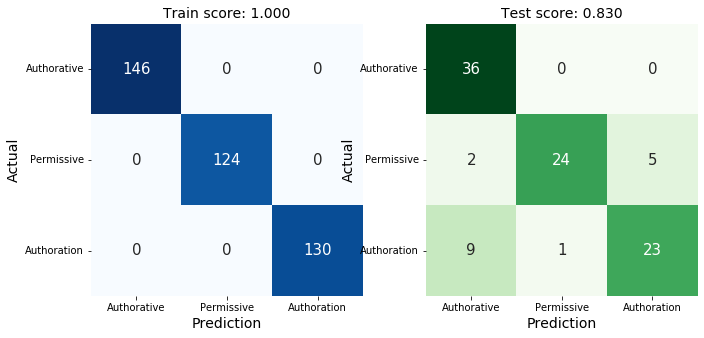

In [19]:
from jcopml.plot import plot_confusion_matrix
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [33]:
X_pred = pd.read_csv("data/parenting_dataset_val.csv", index_col="NO")
X_pred

,Responden,AE1,AE2,AE3,AE4,AE5,AE6,AE7,AE8,AE9,...,PE1,PE2,PE3,PE4,PE5,PE6,PE7,PE8,PE9,PE10
NO,,,,,,,,,,,,,,,,,,,,,
1,Abed Aljabiri Anugrah Arrahman,1,5,2,5,1,4,1,4,1,...,1,4,3,1,4,1,2,4,1,1
2,ABDUL KHOLIK,1,4,2,4,2,5,1,4,5,...,1,2,3,2,3,4,3,2,2,1
3,ADAM NUR ALAM,2,4,4,5,5,4,2,5,5,...,4,4,3,4,4,4,4,4,3,3
4,AIDA RAMARANI,1,3,2,4,2,4,1,3,2,...,5,5,2,4,3,3,3,5,5,4
5,AL QUNAROH BUENA,1,1,3,3,1,1,1,5,3,...,2,5,1,4,3,4,3,4,4,3
6,ANGGI MARFIANI YUSKA,1,5,3,1,1,3,1,5,5,...,4,4,2,4,3,4,2,4,4,4
7,ANNISA OKTAVIANI,5,1,5,1,4,2,5,1,5,...,5,4,3,4,3,4,4,4,3,3
8,ANNISA RAHMADANI,2,4,3,0,2,3,2,5,5,...,4,4,3,4,3,4,4,4,4,3
9,BIMA PARTOGI,3,1,4,2,3,2,2,3,5,...,3,1,3,2,4,4,4,4,4,4


In [34]:
model.predict(X_pred)

C:\Users\ACER\anaconda3\envs\jcopdl\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array(['Authoration', 'Authorative', 'Authorative', 'Permissive',
       'Permissive', 'Authoration', 'Authoration', 'Permissive',
       'Authoration', 'Permissive'], dtype=object)

In [46]:
data1 = [
    [1,4,2,4,2,5,1,4,5,5,4,3,4,4,4,5,5,5,5,4,3,3,3,3,4,4,3,3,4,3,3,3,4,3,4,3,4,3,4,3,3,4,1,2,3,2,3,4,3,2,2,1]
]

In [47]:
X_pred2 = pd.DataFrame(data1, index=["Abu"], columns=X.columns)
X_pred2

,AE1,AE2,AE3,AE4,AE5,AE6,AE7,AE8,AE9,AE10,...,PE1,PE2,PE3,PE4,PE5,PE6,PE7,PE8,PE9,PE10
Abu,1,4,2,4,2,5,1,4,5,5,...,1,2,3,2,3,4,3,2,2,1


In [48]:
model.predict(X_pred2)

array(['Authorative'], dtype=object)

In [37]:
save_model(model.best_estimator_, "pakis_model_v15.h5")

Model is pickled as model/pakis_model_v15.h5


In [45]:
save_model(model.best_estimator_, "model.h5")

Model is pickled as model/model.h5
